In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, TargetEncoder
from sklearn.feature_extraction import FeatureHasher
from sklearn.model_selection import train_test_split

In [2]:
# Load the OKCupid data
# Downloaded on January 18 from https://github.com/rudeboybert/JSE_OkCupid/blob/master/profiles_revised.csv.zip

df = pd.read_csv("profiles_revised.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59946 entries, 0 to 59945
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          59946 non-null  int64  
 1   body_type    54650 non-null  object 
 2   diet         35551 non-null  object 
 3   drinks       56961 non-null  object 
 4   drugs        45866 non-null  object 
 5   education    53318 non-null  object 
 6   ethnicity    54266 non-null  object 
 7   height       59943 non-null  float64
 8   income       59946 non-null  int64  
 9   job          51748 non-null  object 
 10  offspring    24385 non-null  object 
 11  orientation  59946 non-null  object 
 12  pets         40025 non-null  object 
 13  religion     39720 non-null  object 
 14  sex          59946 non-null  object 
 15  sign         48890 non-null  object 
 16  smokes       54434 non-null  object 
 17  speaks       59896 non-null  object 
 18  status       59946 non-null  object 
dtypes: f

In [4]:
# before we go too far, split!
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
# How many values in each category?
print("Feature     Count")
for feat in train.select_dtypes(include="object").columns:
    print(f"{feat:12}{train[feat].nunique()}")

In [ ]:
# look at drinks category

In [ ]:
# Drop nans for demonstration purposes
nona_speaks = train["speaks"].dropna()
encoder = FeatureHasher(n_features=8, input_type="string")
encoded_speaks = encoder.fit_transform(nona_speaks.str.split(", "))

In [ ]:
for s, e in zip(nona_speaks[:5], encoded_speaks[:5]):
    print(f"{s}: {e.todense()}")

In [ ]:
# income vs education
train.groupby("education")["income"].describe()
edu_encoder = TargetEncoder(target_type="continuous")
edu_feat = edu_encoder.fit_transform(train[["education"]],train["income"])

# Look at the target-encoded values
print(f"{'Education':35} Income")
for cat, enc in sorted(zip(edu_encoder.categories_[0], edu_encoder.encodings_[0]), key=lambda e: e[1], reverse=True):
    print(f"{cat:35} ${enc:,.2f}")

## Extra plots
Used in lecture slides, but how they're made isn't very exciting

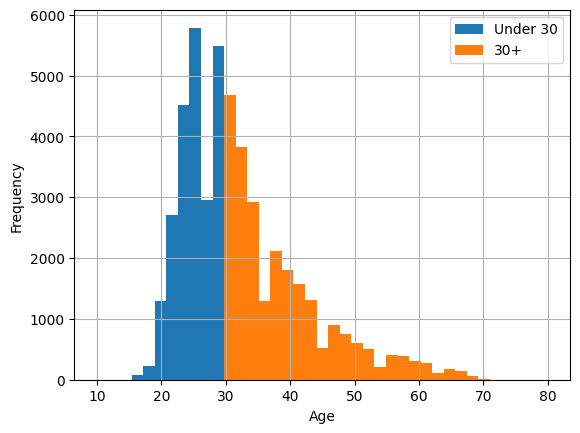

In [36]:
# Discretize age
train["u30"] = train["age"] < 30
bins = np.linspace(10,80,40)
ax = train.query("u30 == 1")["age"].hist(label="Under 30", bins=bins)
train.query("u30 == 0")["age"].hist(label="30+", ax=ax, bins=bins)
plt.legend()
plt.xlabel("Age")
plt.ylabel("Frequency")

plt.savefig("../../static/img/04-discrete.png")